In [3]:
import numpy as np 
import networkx as nx
import dit
from library import equilibrium_dist, dit_dist, pid_dicts
from itertools import product
import matplotlib.pyplot as plt
from dit.pid import PID_WB
%matplotlib inline 

# Micro-State Boolean Network

This is the first time that we'll be doing the full PID on the micro-scale collection of NAND gates, and the macro-scale single logic gate. The "information source" is the A and B "input" nodes, which will randomly change of 0 -> 1 or 1 -> 0 with a probability of 1/2. 

I'll do the PID on the micro- and macro- scales using both the equilibrium distributions AND the maximum enetropy distributions, to see what a difference it makes the system. 

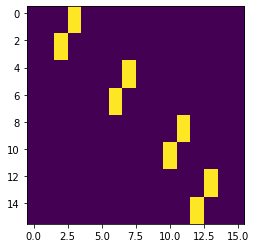

In [21]:
#Starting w/ the Deterministic LUT w/ A and B held constant, to make sure I'm on the right track. 
#I won't do this every time.

mat_micro = np.zeros((16,16))

#The first two elements of the future joint state will always mirror the first two elements of the past state,
#As long as A and B are considered constant.

mat_micro[0][3] = 1 #0000 -> 0011
mat_micro[1][3] = 1 #0001 -> 0011
mat_micro[2][2] = 1 #0010 -> 0010
mat_micro[3][2] = 1 #0011 -> 0010

mat_micro[4][7] = 1 #0100 -> 0111
mat_micro[5][7] = 1 #0101 -> 0111
mat_micro[6][6] = 1 #0110 -> 0110
mat_micro[7][6] = 1 #0111 -> 0110

mat_micro[8][11] = 1 #1000 -> 1011
mat_micro[9][11] = 1 #1001 -> 1011
mat_micro[10][10] = 1 #1010 -> 1010
mat_micro[11][10] = 1 #1011 -> 1010

mat_micro[12][13] = 1 #1100 -> 1101
mat_micro[13][13] = 1 #1101 -> 1101
mat_micro[14][12] = 1 #1110 -> 1100
mat_micro[15][12] = 1 #1111 -> 1100

plt.imshow(mat_micro)

states = ["".join(x) for x in product(["0","1"], repeat=int(np.log2(mat_micro.shape[0])))]
lookup = {states[i]:[int(x) for x in mat_micro[i]] for i in range(mat_micro.shape[0])}

For a first pass, I treated A and B as constants, so we need to ensure make sure that all of the possible outcomes include the random updating of A and B.

We start this by looking at the possible joint-states all the OTHER (not A or B) can be in, and then appending "00", "01", "10" and "11" to the front of them. Since we have two NAND gates, our possible joint-states are also "00" (NAND1 = 0, NAND2 = 0), "01" (NAND1 = 0, NAND2 = 1), and so on. 

Putting them together we get:

In [22]:
for i in range(mat_micro.shape[0]):
    possible_states = ([int(x,2) for x in states if x[2:] == states[np.where(mat_micro[i] == 1)[0][0]][2:]])
    mat_micro[i][possible_states] = 0.25

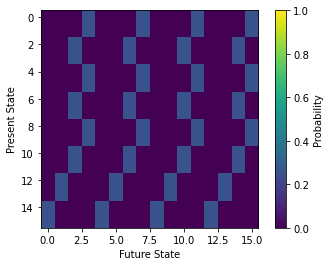

In [23]:
plt.imshow(mat_micro, vmin=0, vmax=1)
plt.ylabel("Present State")
plt.xlabel("Future State")
plt.colorbar(label="Probability")

We can double check that all this works by running through a few rows manually. Take the top row: at time $t$, our system is in 0000.

At time t+1, for things might have happened. If AB = 00, then the joint-state of the system is 0011 (column 4). If AB = 11, then the joint-state of the system is 1111 (column 15). If AB=01, then the system is in 0111 (columnn 7) and if AB=10, then the system is in 1011 (column 11). These all check out. 

If at time $t$ the system is in 1111, then if AB=00, the whole system = 00, if AB=11, then the whole system = 1100 (column 12), and so on. These seem to have worked quite well. 

Does this thing have a well-behaved equilibrium distribution?


In [24]:
pi = equilibrium_dist(mat_micro)
print(pi)

[0.046875 0.015625 0.140625 0.046875 0.046875 0.015625 0.140625 0.046875
 0.046875 0.015625 0.140625 0.046875 0.046875 0.015625 0.140625 0.046875]


Sort of? It visits every state, but not all of them equally. We will use this to construct our PID.

In [25]:
Dist = dit_dist(pi, mat_micro)
print(Dist)

Class:          Distribution
Alphabet:       (('0', '1'), ('0', '1'), ('0', '1'), ('0', '1'), ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'))
Base:           linear
Outcome Class:  str
Outcome Length: 5
RV Names:       None

x       p(x)
0000D   0.011718750000000005
0000H   0.011718750000000005
0000L   0.011718750000000005
0000P   0.011718750000000005
0001D   0.0039062499999999653
0001H   0.0039062499999999653
0001L   0.0039062499999999653
0001P   0.0039062499999999653
0010C   0.03515625000000008
0010G   0.03515625000000008
0010K   0.03515625000000008
0010O   0.03515625000000008
0011C   0.011718749999999977
0011G   0.011718749999999977
0011K   0.011718749999999977
0011O   0.011718749999999977
0100D   0.01171875
0100H   0.01171875
0100L   0.01171875
0100P   0.01171875
0101D   0.003906249999999951
0101H   0.003906249999999951
0101L   0.003906249999999951
0101P   0.003906249999999951
0110C   0.03515625000000007
0110G   0.03515625000000007
0110K   0.035156

Now for the PID:

In [9]:
imin_micro = PID_WB(Dist)

In [11]:
micro_lattice_order, micro_pid_results = pid_dicts(imin_micro)

bundle = np.array([micro_lattice_order, micro_pid_results], dtype="object")
np.savez_compressed("AND_micro_PID_dicts.npz", bundle)

lattice = imin_micro._lattice._lattice
node_tups = sorted(lattice)
node_strs = [(''.join('{{{}}}'.format(':'.join(map(str, n))) for n in node)) for node in sorted(lattice.nodes)]

mapping = {node_tups[i] : node_strs[i] for i in range(len(node_tups))}
and_micro_lattice = nx.relabel_nodes(lattice, mapping)

nx.write_edgelist(and_micro_lattice,"AND_micro_lattice.edgelist")

# Macro AND Gate

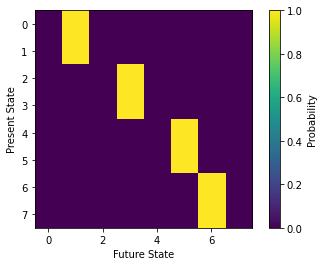

In [12]:
mat_macro = np.zeros((8,8))
mat_macro[0][1] = 1 #000 -> 000
mat_macro[1][1] = 1 #001 -> 000

mat_macro[2][3] = 1 #010 -> 010
mat_macro[3][3] = 1 #011 -> 010

mat_macro[4][5] = 1 #100 -> 100
mat_macro[5][5] = 1 #101 -> 100

mat_macro[6][6] = 1 #110 -> 111
mat_macro[7][6] = 1 #111 -> 111


plt.imshow(mat_macro)
plt.ylabel("Present State")
plt.xlabel("Future State")
plt.colorbar(label="Probability")

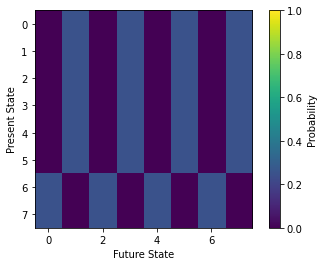

In [13]:
macro_states = ["000","001","010","011","100","101","110","111"]
for i in range(mat_macro.shape[0]):
    possible_states = ([int(x,2) for x in macro_states if x[2:] == macro_states[np.where(mat_macro[i] == 1)[0][0]][2:]])
    mat_macro[i][possible_states] = 0.25
    
plt.imshow(mat_macro, vmin=0, vmax=1)
plt.ylabel("Present State")
plt.xlabel("Future State")
plt.colorbar(label="Probability")

Under the equilibrium probability distribution:

In [15]:
pi_macro = pi = equilibrium_dist(mat_macro)
print(pi_macro)
print("")
Dist_macro = dit_dist(pi_macro, mat_macro)
print(Dist_macro)
print("")


[0.0625 0.1875 0.0625 0.1875 0.0625 0.1875 0.0625 0.1875]

Class:          Distribution
Alphabet:       (('0', '1'), ('0', '1'), ('0', '1'), ('0', '1', '2', '3', '4', '5', '6', '7'))
Base:           linear
Outcome Class:  str
Outcome Length: 4
RV Names:       None

x      p(x)
0001   0.015625
0003   0.015625
0005   0.015625
0007   0.015625
0011   0.04687500000000001
0013   0.04687500000000001
0015   0.04687500000000001
0017   0.04687500000000001
0101   0.015624999999999986
0103   0.015624999999999986
0105   0.015624999999999986
0107   0.015624999999999986
0111   0.04687500000000001
0113   0.04687500000000001
0115   0.04687500000000001
0117   0.04687500000000001
1001   0.015624999999999986
1003   0.015624999999999986
1005   0.015624999999999986
1007   0.015624999999999986
1011   0.046875
1013   0.046875
1015   0.046875
1017   0.046875
1100   0.015624999999999995
1102   0.015624999999999995
1104   0.015624999999999995
1106   0.015624999999999995
1110   0.046875
1112   0.046875
1114   0.0

In [16]:
imin_macro = PID_WB(Dist_macro)
print(imin_macro)

+-----------------+--------+--------+
|      I_min      |  I_r   |   pi   |
+-----------------+--------+--------+
|     {0:1:2}     | 0.8113 | 0.0000 |
|      {0:1}      | 0.8113 | 0.5000 |
|      {0:2}      | 0.3113 | 0.0000 |
|      {1:2}      | 0.3113 | 0.0000 |
|    {0:1}{0:2}   | 0.3113 | 0.0000 |
|    {0:1}{1:2}   | 0.3113 | 0.0000 |
|    {0:2}{1:2}   | 0.3113 | 0.0000 |
| {0:1}{0:2}{1:2} | 0.3113 | 0.0000 |
|       {0}       | 0.3113 | 0.0000 |
|       {1}       | 0.3113 | 0.0000 |
|       {2}       | 0.0000 | 0.0000 |
|     {0}{1:2}    | 0.3113 | 0.0000 |
|     {1}{0:2}    | 0.3113 | 0.0000 |
|     {2}{0:1}    | 0.0000 | 0.0000 |
|      {0}{1}     | 0.3113 | 0.3113 |
|      {0}{2}     | 0.0000 | 0.0000 |
|      {1}{2}     | 0.0000 | 0.0000 |
|    {0}{1}{2}    | 0.0000 | 0.0000 |
+-----------------+--------+--------+


In [17]:
macro_lattice_order, macro_pid_results = pid_dicts(imin_macro)

bundle = np.array([macro_lattice_order, macro_pid_results], dtype="object")
np.savez_compressed("AND_macro_PID_dicts.npz", bundle)

In [18]:
lattice = imin_macro._lattice._lattice
node_tups = sorted(lattice)
node_strs = [(''.join('{{{}}}'.format(':'.join(map(str, n))) for n in node)) for node in sorted(lattice.nodes)]

mapping = {node_tups[i] : node_strs[i] for i in range(len(node_tups))}
and_micro_lattice = nx.relabel_nodes(lattice, mapping)

nx.write_edgelist(and_micro_lattice,"AND_macro_lattice.edgelist")

Under conditions of maximum entropy, most of it looks the same:

# Comparing Macro and Micro 
So, how do we compare all these distributions. Let's look at the two equilibrium dist distributions

In [19]:
print(imin_micro)

+--------------------------------+--------+--------+
|             I_min              |  I_r   |   pi   |
+--------------------------------+--------+--------+
|           {0:1:2:3}            | 1.6226 | 0.0000 |
|            {0:1:2}             | 1.6226 | 0.3903 |
|            {0:1:3}             | 0.8113 | 0.0000 |
|            {0:2:3}             | 1.1226 | 0.0000 |
|            {1:2:3}             | 1.1226 | 0.0000 |
|         {0:1:2}{0:1:3}         | 0.8113 | 0.0000 |
|         {0:1:2}{0:2:3}         | 1.1226 | 0.0000 |
|         {0:1:2}{1:2:3}         | 1.1226 | 0.0000 |
|         {0:1:3}{0:2:3}         | 0.7016 | 0.0000 |
|         {0:1:3}{1:2:3}         | 0.7016 | 0.0000 |
|         {0:2:3}{1:2:3}         | 1.1226 | 0.0000 |
|     {0:1:2}{0:1:3}{0:2:3}      | 0.7016 | 0.0000 |
|     {0:1:2}{0:1:3}{1:2:3}      | 0.7016 | 0.0000 |
|     {0:1:2}{0:2:3}{1:2:3}      | 1.1226 | 0.0000 |
|     {0:1:3}{0:2:3}{1:2:3}      | 0.7016 | 0.0000 |
|             {0:1}              | 0.8113 | 0.

In [20]:
print(imin_macro)

+-----------------+--------+--------+
|      I_min      |  I_r   |   pi   |
+-----------------+--------+--------+
|     {0:1:2}     | 0.8113 | 0.0000 |
|      {0:1}      | 0.8113 | 0.5000 |
|      {0:2}      | 0.3113 | 0.0000 |
|      {1:2}      | 0.3113 | 0.0000 |
|    {0:1}{0:2}   | 0.3113 | 0.0000 |
|    {0:1}{1:2}   | 0.3113 | 0.0000 |
|    {0:2}{1:2}   | 0.3113 | 0.0000 |
| {0:1}{0:2}{1:2} | 0.3113 | 0.0000 |
|       {0}       | 0.3113 | 0.0000 |
|       {1}       | 0.3113 | 0.0000 |
|       {2}       | 0.0000 | 0.0000 |
|     {0}{1:2}    | 0.3113 | 0.0000 |
|     {1}{0:2}    | 0.3113 | 0.0000 |
|     {2}{0:1}    | 0.0000 | 0.0000 |
|      {0}{1}     | 0.3113 | 0.3113 |
|      {0}{2}     | 0.0000 | 0.0000 |
|      {1}{2}     | 0.0000 | 0.0000 |
|    {0}{1}{2}    | 0.0000 | 0.0000 |
+-----------------+--------+--------+


The macro distribution has 2.17x more mutual information between past and future, so going from the NAND-construction to the basic AND construction looses a lot of information about the internal networks of what's happening. This is expected, I think. 

The macro PID lattice has only 2 non-zero atoms: \{0:1\} (0.5 bit) and \{0\}\{1\} (0.3113 bit).

The micro PID latttice has 38 non-zero atoms (I won't list them all, but everything is represented - synergy, redundancy, the works).

It does not look to me as though there is an obvious move from "lower" on the lattice to "higher" on the lattice, if I am being honest. In contrast, it seems like our coarse-graining procedure is just throwing out lots of information. If we had a system where MI_micro = MI_macro and the macro state was smaller, it would be a much more compelling story, I feel. 